In [1]:
suppressPackageStartupMessages(library(dplyr)) 
library(ggplot2)
library(pheatmap)
library(repr)
library(RColorBrewer)
suppressPackageStartupMessages(library(Seurat))
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")

Warning message:
“package ‘pheatmap’ was built under R version 4.3.2”
Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: Rcpp

Warning message:
“package ‘dichromat’ was built under R version 4.3.2”
Warning message:
“package ‘viridis’ was built under R version 4.3.2”
Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [3]:
path <- '/projects/ps-renlab2/y2xie/projects/77.LC/81.FNIH_DPT_IGM_240827/'
subdir <- "./"

## Step1: histone mod filtering

In [4]:
meta <- read.table(paste0(path, "scripts/heart_pool_metadata.xls"))
dsample <- meta$V1
rsample <- meta$V2

dsample
rsample

[1] "QY_2600" "QY_2602" "QY_2604" "QY_2606" "QY_2608" "QY_2610" "QY_2612"
 [8] "QY_2614" "QY_2616" "QY_2618" "QY_2620" "QY_2622" "QY_2624" "QY_2626"
[15] "QY_2661" "QY_2663"

[1] "QY_2601" "QY_2603" "QY_2605" "QY_2607" "QY_2609" "QY_2611" "QY_2613"
 [8] "QY_2615" "QY_2617" "QY_2619" "QY_2621" "QY_2623" "QY_2625" "QY_2627"
[15] "QY_2662" "QY_2664"

In [10]:
frip <- list()
for (s in dsample){
    frip[[s]] <- ImportArcFRiP(raw_count = paste0(path, "09.macs2/", s, "_clean_fragments.tsv.gz_Count.xls"),
                         frip_count = paste0(path, "09.macs2/", s, "_FRiP_fragments.tsv_Count.xls"))
    frip[[s]]$sample <- s
}

In [ ]:
### Set manual cutoff
cutoff <- data.frame(sample = names(frip),
                   xcut = c(500, 500, 700, 700, 700, 700, 800, 1000, 1000, 1000, 1000,1000, 700, 1000, 700, 700),
                   ycut = c(0.3, 0.3, 0.55, 0.55, 0.25, 0.25, 0.5, 0.55, 0,2, 0.2, 0.5, 0.5, 0.3, 0.25, 0.6, 0.6), 
                   ycut2 = c(0.8, 0.8, 0.95, 0.95, 0.75, 0.75, 0.9, 0.9, 0.75, 0.75, 0.9, 0.9, 0.8, 0.8, 0.95, 0.95))

In [17]:
valid <- list()
for (f in cutoff$sample){
    valid[[f]] <- PlotArcFRiP_d(frip[[f]], xcut_low = cutoff[cutoff$sample ==f, "xcut"], 
                              ycut_low = cutoff[cutoff$sample ==f, "ycut"], 
                              ycut_high = cutoff[cutoff$sample ==f, "ycut2"], 
                              prefix = f)
}

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


## Step2: paired modalities filtering

In [19]:
valid <- list()

In [18]:
translate <- read.table("/projects/ps-renlab/y2xie/projects/genome_ref/arc_bc-translation.txt", header = T, row.names = 1, sep = "\t")
translate$atac <- paste0(translate$atac, "-1")
translate$rna <- paste0(translate$rna, "-1")

In [22]:
### example
i = 16
ds = dsample[i]
rs = rsample[i]

tmp1 <- read.table(paste0(path, "09.macs2/", subdir, ds, "_clean_fragments.tsv.gz_Count.xls")) %>% 
setNames(c("dna_raw", "dna_unique")) %>%
dplyr::select(dna_unique)

rownames(tmp1) <- translate[match(rownames(tmp1), translate$atac),]$rna

tmp2 <- Read10X(paste0(path, "/RNA/", rs, "/outs/raw_feature_bc_matrix")) %>% 
colSums() %>% as.data.frame() %>% 
setNames("rna")

tf <- merge(x = tmp1, y = tmp2, by = 0) %>% 
setNames(c("bc", "dna_count", "rna_count"))

In [23]:
xcutoff = 700
ycutoff = 500
valid[[i]] <- PlotArcPair_d(pair = tf, dcutoff = xcutoff, rcutoff = ycutoff, 
                            prefix = paste0(ds, "_", rs), names = "rna")

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


## Summary for all libraries

In [24]:
valid <- list()
for (i in 1:length(dsample)){
    ds = dsample[i]
    rs = rsample[i]

    valid1 <- read.table(paste0(ds, "_", rs, "_valid_cells.xls"), sep = "\t", header = T)
    valid2 <- read.table(paste0(ds, "_PF_cells.txt"), sep = "\t")[,1:6]
    colnames(valid2) <- c("atac", "all", "all_dedup", "peak", "peak_dedup", "frip")
    valid[[ds]] <- merge(valid1, valid2, by = "atac") %>% mutate(dsample = ds, rsample = rs)
}

valid <- do.call(rbind, valid)
cnumber <- table(valid$dsample) %>% as.data.frame 
valid <- merge(valid, meta, by.x = "dsample", by.y = "V1")
valid$target <- gsub("^([^_]+)_([^_-]+).*", "\\2", valid$V4)

head(valid)

,dsample,atac,rna,dna_count,rna_count,all,all_dedup,peak,peak_dedup,frip,rsample,V2,V3,V4,target
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,QY_2600,AAACAAGCAAGTCCTT-1,GGCTAGTGTTGTGATG-1,4718,1149,17880,4718,9454,2392,0.5069945,QY_2601,QY_2601,Heart,pool-1_H3K27ac-1,H3K27ac
2,QY_2600,AAACAAGCAGAATCTG-1,GGCTAGTGTCTTGCAT-1,1970,3908,6598,1970,4740,1362,0.6913706,QY_2601,QY_2601,Heart,pool-1_H3K27ac-1,H3K27ac
3,QY_2600,AAACAAGCAGGTGAGA-1,GGCTAGTGTTCGCTCA-1,4938,2973,18677,4938,12152,3144,0.6366950,QY_2601,QY_2601,Heart,pool-1_H3K27ac-1,H3K27ac
4,QY_2600,AAACCAGGTAATTGGG-1,GTTTAACCACCATATG-1,1418,6819,5278,1418,2408,662,0.4668547,QY_2601,QY_2601,Heart,pool-1_H3K27ac-1,H3K27ac
5,QY_2600,AAACCAGGTACCTTAA-1,GTTTAACCAGTAGGTG-1,816,8065,2956,816,1866,512,0.6274510,QY_2601,QY_2601,Heart,pool-1_H3K27ac-1,H3K27ac
6,QY_2600,AAACCAGGTCGGTTAT-1,GTTTAACCAGTTTGGC-1,2284,1853,8068,2284,4487,1232,0.5394046,QY_2601,QY_2601,Heart,pool-1_H3K27ac-1,H3K27ac


Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


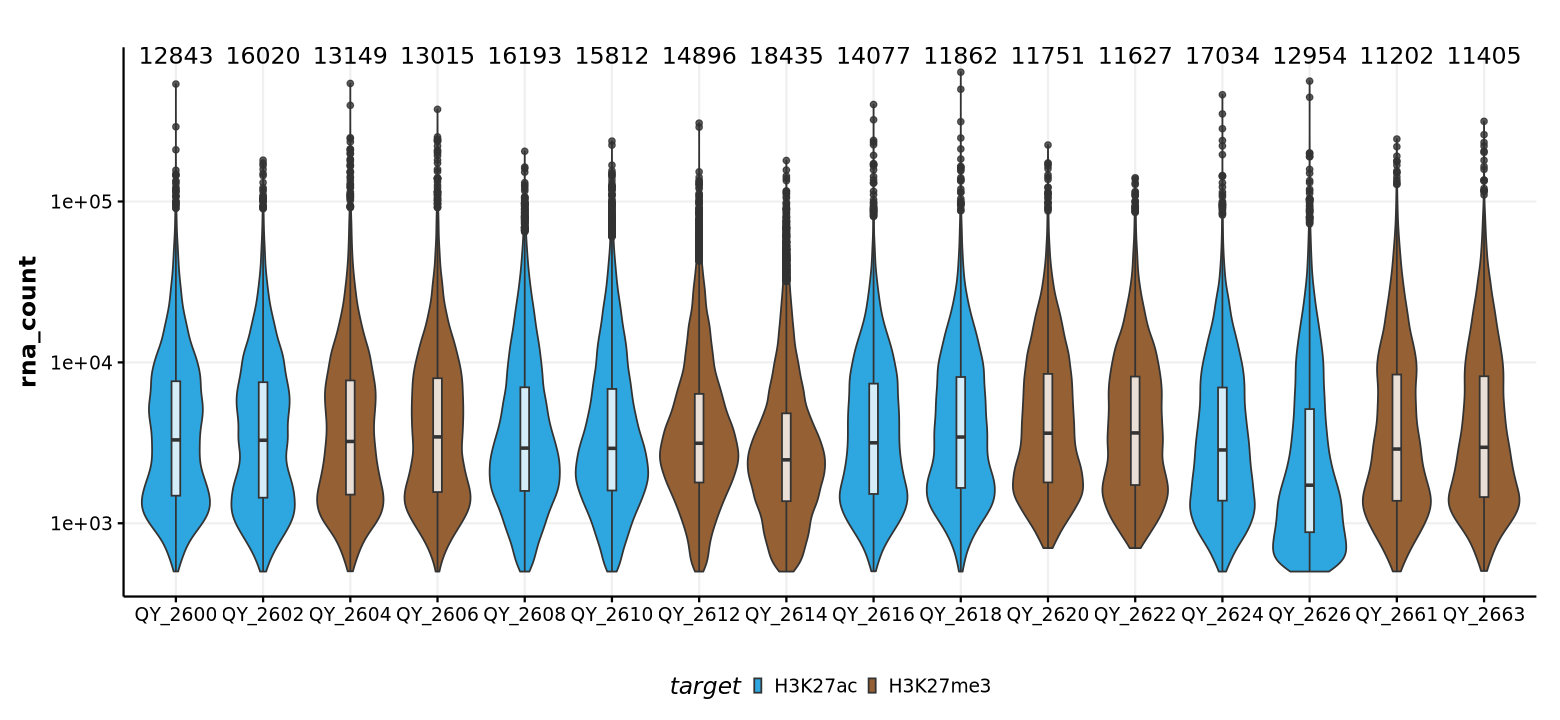

In [27]:
options(repr.plot.width = 13, repr.plot.height = 6)
valid %>%
ggplot(aes(x = dsample, y = rna_count)) + 
geom_violin(aes(fill = target)) + 
geom_boxplot(fill = "white", alpha = 0.8, width = 0.1) + 
geom_text(data = cnumber, aes(x = Var1, y = max(valid$rna_count), label = Freq), 
              vjust = -0.5, size = 5, color = "black") + 
scale_y_log10() + xlab("") + 
theme_Publication() +
scale_fill_manual(values = c("#2EA7E0", "#956134"))

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


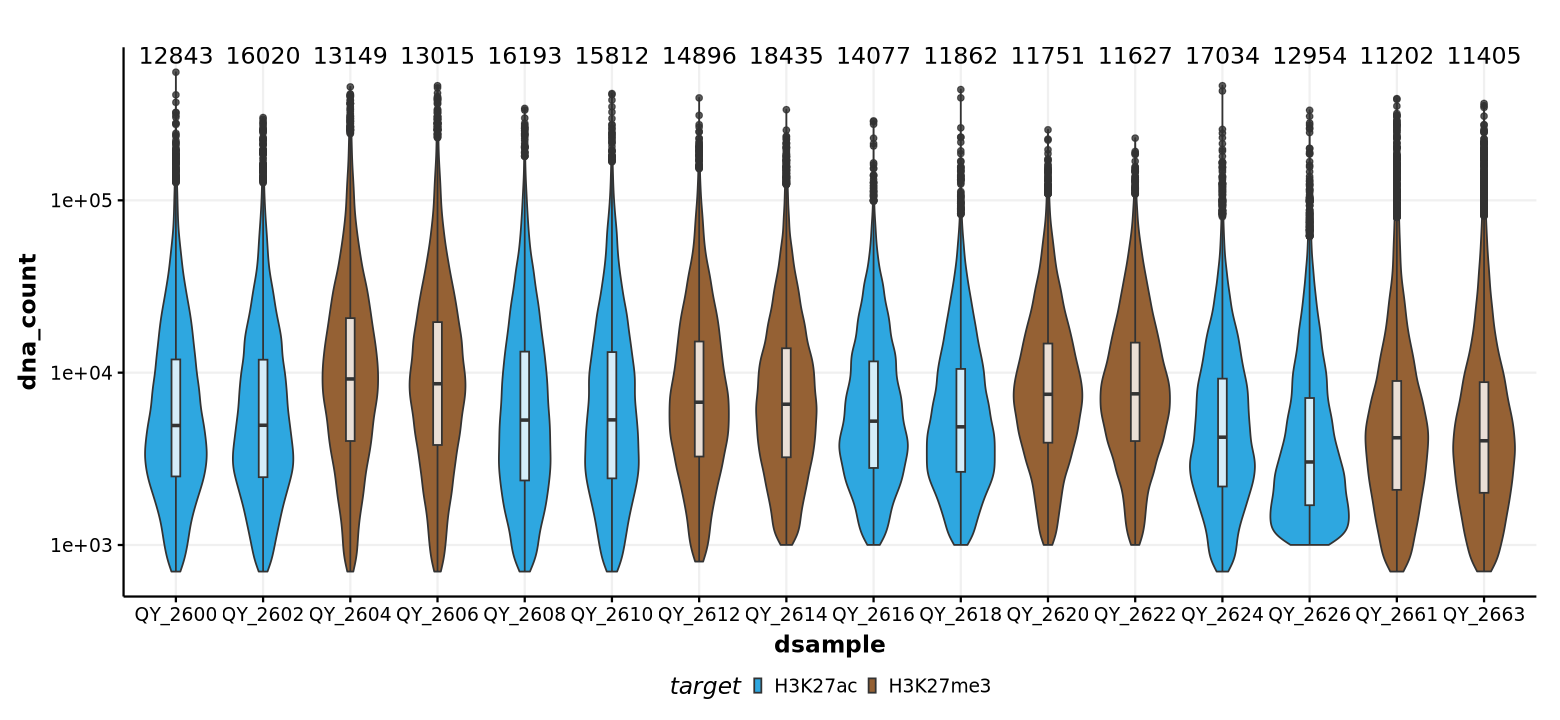

In [26]:
options(repr.plot.width = 13, repr.plot.height = 6)
valid %>%
ggplot(aes(x = dsample, y = dna_count)) + 
geom_violin(aes(fill = target)) + 
geom_boxplot(fill = "white", alpha = 0.8, width = 0.1) + 
geom_text(data = cnumber, aes(x = Var1, y = max(valid$dna_count), label = Freq), 
              vjust = -0.5, size = 5, color = "black") + 
scale_y_log10() + 
theme_Publication() +
scale_fill_manual(values = c("#2EA7E0", "#956134"))

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


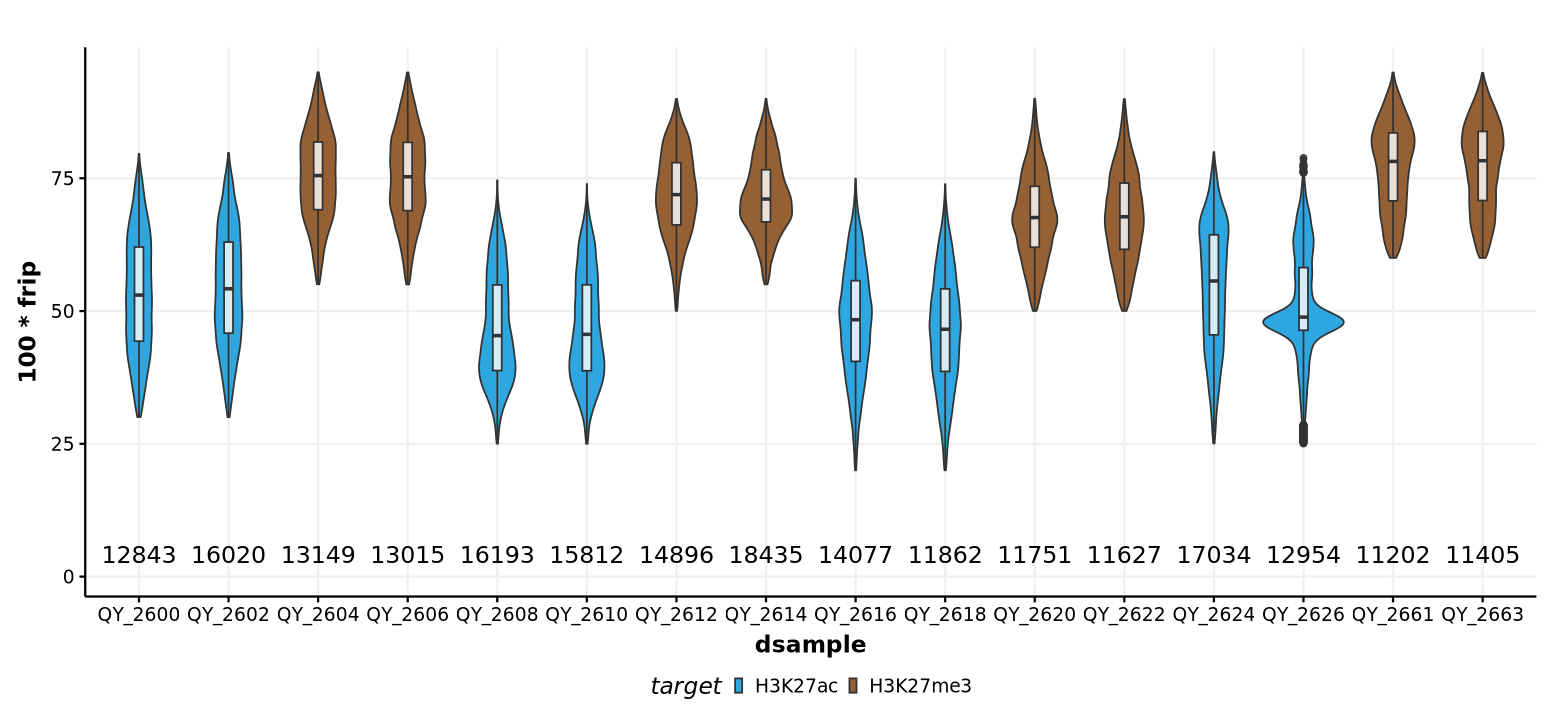

In [29]:
options(repr.plot.width = 13, repr.plot.height = 6)
valid %>%
ggplot(aes(x = dsample, y = 100*frip)) + 
geom_violin(aes(fill = target)) + 
geom_boxplot(fill = "white", alpha = 0.8, width = 0.1) + 
geom_text(data = cnumber, aes(x = Var1, y = max(valid$frip), label = Freq), 
              vjust = -0.5, size = 5, color = "black") + 
theme_Publication() +
scale_fill_manual(values = c("#2EA7E0", "#956134"))